## Setup
### Libraries

In [153]:
%load_ext autoreload
%autoreload 2
import pycountry
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Load Data

In [154]:
panel_df = pd.read_csv('../data/processed/section_series_sum_small/panel.csv', index_col=['city','year'])
panel = xr.Dataset.from_dataframe(panel_df)

## Modeling
### VAR Meta Model
Run a vector autoregression for every city with 3 lags, estimating the impact of the earthquake dummy.

In [72]:
%%R
library('dynlm')
library('vars')
library('dplyr')

/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:MASS’:

    select


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


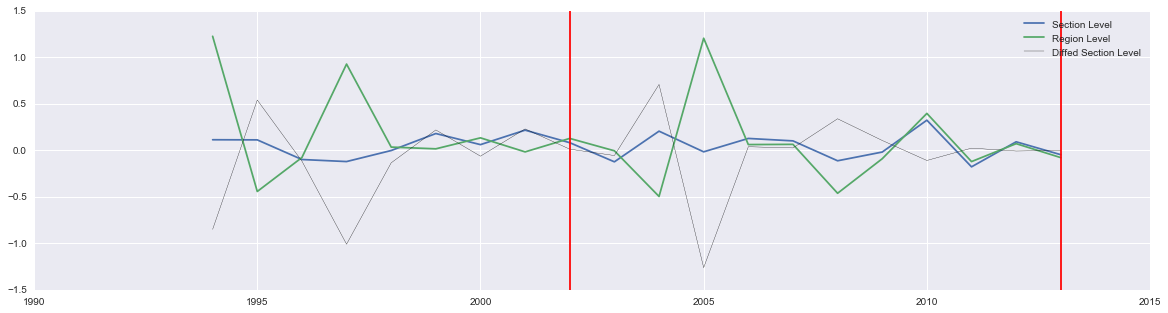

In [71]:
df = panel.sel(city='bushehr').to_dataframe()
plt.figure(figsize=(20,5))
plt.plot(df.sum_lum.pct_change(), label='Section Level')
plt.plot(df.region_sum_lum.pct_change(), label='Region Level')
plt.plot(df.sum_lum.pct_change() - df.country_sum_lum.pct_change(), label='Diffed Section Level', c='black', lw=.3)
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.name, c='r')

plt.legend()
plt.show()

In [96]:
r_panel = panel_df.reset_index().dropna(axis=0)

In [240]:
%%R -i r_panel -o results
cities <- unique(r_panel$city)
results <- data.frame('city'=c(0),'el1'=c(0),'el2'=c(0),'el3'=c(0))

for (city in cities){
    lags = 3
    data <- r_panel[r_panel$city == city,][-lags]
    city_data <- data.frame(diff(as.matrix(data[,c('inflation','imports','exports')])))
    city_data$earthquake_dummy <- as.numeric(data$earthquake_dummy[-1])
    city_data$diff_sum_lum <- diff(data$sum_lum) - diff(data$country_sum_lum)
    var <- VAR(city_data, p=lags)
    result <- data.frame(
        'city'= c(city),
        'el1'= c(var$varresult$diff_sum_lum$coefficients['diff_sum_lum.l1']),
        'el3'= c(var$varresult$diff_sum_lum$coefficients['diff_sum_lum.l3']),
        'el2'= c(var$varresult$diff_sum_lum$coefficients['diff_sum_lum.l2'])
    )
    results <- rbind(results,result)
}
rownames(results) <- results$city
results <- results[c('el1','el2','el3')]

In [241]:
filtered_results = results.dropna(axis=0)

### Average Earthquake Coefficient
Combine the earthquake lag coefficients from all the models

Average Coefficients: 
el1   -0.3762
el2   -0.3721
el3   -0.3310
dtype: float64


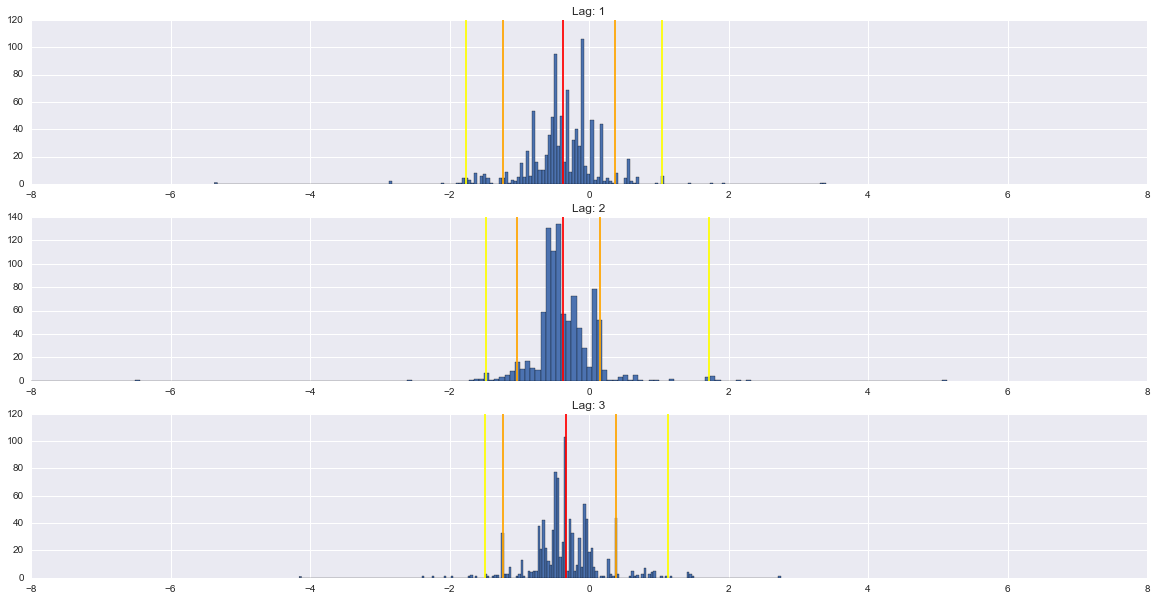

In [242]:
fig, axs = plt.subplots(3,1,figsize=(20,10))
print('Average Coefficients: \n{}'.format(filtered_results.mean()))
for i, ax in enumerate(axs.flat):
    ax.hist(filtered_results['el'+str(i+1)], bins=200)
    ax.set_xlim([-8,8])
    ax.set_title('Lag: {}'.format(i+1))
    ax.axvline(filtered_results['el'+str(i+1)].mean(), c='r')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 5), c='orange')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 95), c='orange')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 1), c='yellow')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 99), c='yellow')
    
plt.show()

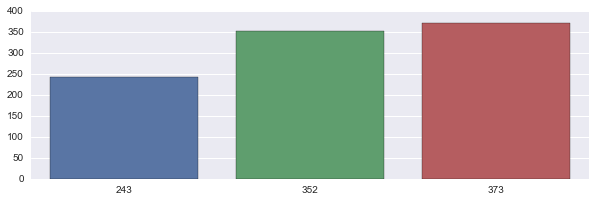

In [243]:
win_counts = filtered_results.apply(lambda r: r.argmax(), axis=1).value_counts()
plt.figure(figsize=(10,3))
sns.barplot(x=win_counts.index, y=win_counts.index, data=win_counts)
plt.show()